# Drinking Water Quality Prediction
Project 1 for the *Explainable Automated Machine Learning* (LTAT.02.023) course

**Authors**: <br>
Dmitri Rozgonjuk <br>
Lisanna Lehes <br>
Marilin Moor <br>

## Background
tbw

### Setup

In [1]:
# Install packages
#!pip install hyperopt
#!pip install git+https://github.com/hyperopt/hyperopt.git
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn
#!pip install xgboost

In [2]:
# Libraries
## Data frames and arrays
import pandas as pd
import numpy as np

## Model training and evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
from hpsklearn import HyperoptEstimator, gradient_boosting_classifier, ada_boost_classifier,\
random_forest_classifier, logistic_regression, linear_discriminant_analysis # add more classifiers

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Differences testing
from scipy.stats import friedmanchisquare # Friedman chi-squared test 
import scikit_posthocs as sp # post-hocs (here, e.g, Nemenyi test)

## Misc
import time
from statsmodels.stats.contingency_tables import mcnemar # McNemar test
import warnings
warnings.filterwarnings("ignore")

## Data Description
üldine jutt

In [3]:
# data import, mingid kirjeldavad plotid, missing data, jne

## Data Preparation
Siia tulevad Marilini andmete puhastamise koodi põhjendused

In [4]:
# kood andmete puhastamiseks

All on juba puhas kood

In [5]:
# MM
train_df = pd.read_csv("clean_data/train.csv")
test_df = pd.read_csv("clean_data/test.csv")

y_train = train_df['compliance_2020']
X_train = train_df.drop(columns = ['compliance_2020', 'compliance_2021'])

# Test data
y_test = test_df['compliance_2020']
X_test = test_df.drop(columns = ['compliance_2020'])

print(f'X_train dims: {X_train.shape}')
print(f'y_train dims: {y_train.shape}')

#print(f'X_val dims: {X_val.shape}')
#print(f'y_val dims: {y_val.shape}')

print(f'X_test dims: {X_test.shape}')
print(f'y_test dims: {y_test.shape}')

X_train dims: (388, 27)
y_train dims: (388,)
X_test dims: (156, 27)
y_test dims: (156,)


## Baseline Model Selection
In the following section we are selecting and testing the baseline accuracy of 13 classifiers. Insipiration for the classifier selection can be found from [here](https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods) and [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

### An overview of classifiers
Here we are testing 13 different classification algorithms. Algorithms were chosen so that they would  be different and work on a classification task. Altogether we have chosen algorithms from the following sklearn classes:

**Ensemble** algorithms that combine several base models in order to produce the most optimal model. We have 3 boosting and 1 bagging algorithm. **Boosting Models** speciality is that they are trying to improve the prediction power by training a sequence of weak models while each new model is trying to correct the errors made by the previous ones ([source](https://towardsdatascience.com/boosting-algorithms-explained-d38f56ef3f30)). **Bagging models** speciality is that they are training a bunch of individual models in a parallel way, so that each model is trained by a random subset of the data ([source](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725)).
- [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) assigns weights to miss-classified datapoints, so that the next classifier would pay extra attention to these poins and therefore, get them right.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) uses decision trees as its weak predictors
- [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=adaboostclassifer) focuses on the difference between the prediction and the ground truth. 
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) uses bagging as the ensemble method and decision tree as the individual model.

**Discriminant Analysis** is used to assign objects to one group among a number of known groups. 
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) is a linear model for classification and works by calculating summary statistics for the input features by class label, such as the mean and standard deviation. These statistics represent the model learned from the training data.
- [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)  is particularly useful if there is prior knowledge that individual classes exhibit distinct covariances.

**Linear models** are a set of methods intended for regression in which the target value is expected to be a linear combination of the features.
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) is a linear model for classification. 
- [SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a linear classifier optimized by SGD which implements various regularised linear models by modifying the parameter “loss”.

**Naive Bayes**. These methods are a set of supervised learning algorithms based on applying Bayes’ theorem that has an assumption of independence among predictors.
- [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) is a probabilistic classification algorithm based on applying Bayes' theorem with strong independence assumptions.

**Gaussian Process** allows to shape your prior belief via the choice of kernel. Also, the greatest practical advantage is that they can give a reliable estimate of their own uncertainty.
- [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html) is a non-parametric algorithm that can be applied to binary classification tasks. 

**Neighbours** module implements the k-nearest neighbors algorithm.
- [Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) assumes that similar things exist in close proximity, meanind that similar things are near to each other.

**Tree** module includes decision tree-based models for classification and regression.
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) can be used to visually and explicitly represent decisions and decision making. 

**SVM** is a linear model for classification (and regression) problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is based on a line or a hyperplane which separates the data into classes.
- [RBF SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) is an SVM that uses RBF kernel that is one a widely used kernel due to its similarity to the Gaussian distribution. The RBF kernel function for two points computes the similarity or how close they are to each other.

### Classifiers and their search spaces (for further use in the HPO section)
Below we are assemblying a dataframe of classifiers (their names and operatinalizations) as well as manually defined search spaces to be used later in the hyperparameter optimization (HPO) task. We decided to add the HPO search spaces already here to provide a consistent code that allows for smoother readability and automation of tasks.

In [6]:
names = [
    "K-Nearest Neighbors",
    "SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "Logistic Regression",
    "XGBoost",
    "SGD",
    "Gradient Boosting Classifier"
]

classifiers = [
    KNeighborsClassifier(),
    SVC(), # kernel = "rbf" by default
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier()
]

search_spaces = [
    
    # KNN
    {
        'n_neighbors' : hp.choice('n_neighbors', range(2, 20, 1)), # default = 5
        'weights': hp.choice('weights', ['uniform', 'distance']), # default = 'uniform'
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']), # default = 'auto' 
        'leaf_size': hp.choice('leaf_size', range(10, 40, 1)), # default=30
        'p': hp.choice('p', [1, 2]) # default=2
    },
    
    #SVM
    {
        'C': hp.uniform('C', 0, 1), # default = 1.0
        'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']), # default=’rbf’
     #   'shrinking': hp.choice('shrinking', [True, False]), # default=True
    },
    
    # Gaussian Process
    {},
    
    # Decision Tree
    {},
       
    # Random Forest
    {
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'min_samples_split': hp.choice('min_samples_split', range(2, 7, 1)), # default=2
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # default='sqrt'
    },
    
    # AdaBoost
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=1.0
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        
    },
    
    # Naive Bayes
    {},
    
    # QDA
    {},
    
    # LDA
    {
        'solver': hp.choice('solver', ['lsqr', 'eigen']), # default=’svd’
        'shrinkage': hp.uniform('shrinkage', 0.01, 1), # default=None # not supported with 'svd' solver
        
    },
    
    # Logistic Regression
    { 
        'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']), # default=’l2’
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'C': hp.uniform('C', 0, 1), # default = 1.0
        'solver': hp.choice('solver', ['saga','saga'])  # # use solver = 'saga' for using different penalties (here, give a pseudo-choice)
    },
    
    # XGBoost
    {},
    
    # SGD
    {},

    # GBC
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=0.1
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'subsample': hp.uniform('subsample', 0.60, 1.0), # default=1.0
    #    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), # default=None
     #   'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0), # default=2 # NB! decided for using float instead of int
     #  'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0, 1.0), # default=1 # NB! decided for using float instead of int
     #   'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5), # default=0.0
        'max_depth': hp.choice('max_depth', range(1,20)), # default=3
    #    'warm_start': hp.choice('warm_start', [True, False])
        
    }
    

]

# Dataframe for model names, classes, and search spaces
df_models = pd.DataFrame({'name': names, 'classifier': classifiers, 'search_space' : search_spaces})
df_models['n_hp'] = df_models['search_space'].map(len) # the number of hyperparameters in search space

In [7]:
df_models

,name,classifier,search_space,n_hp
0,K-Nearest Neighbors,KNeighborsClassifier(),{'n_neighbors': 0 switch 1 hyperopt_param 2 ...,5
1,SVM,SVC(),{'C': 0 float 1 hyperopt_param 2 Literal...,2
2,Gaussian Process,GaussianProcessClassifier(),{},0
3,Decision Tree,DecisionTreeClassifier(),{},0
4,Random Forest,RandomForestClassifier(),{'n_estimators': 0 switch 1 hyperopt_param 2...,3
5,AdaBoost,AdaBoostClassifier(),{'learning_rate': 0 float 1 hyperopt_param 2...,2
6,Naive Bayes,GaussianNB(),{},0
7,QDA,QuadraticDiscriminantAnalysis(),{},0
8,LDA,LinearDiscriminantAnalysis(),{'solver': 0 switch 1 hyperopt_param 2 L...,2
9,Logistic Regression,LogisticRegression(),{'penalty': 0 switch 1 hyperopt_param 2 ...,4


Because some of the classifiers have very varying results depending on the random state, we run them trough 100 iterations to get their average accuracy score. We use accuracy score to compare the baseline models.

In [8]:
# Define the number of iterations
iterations = 100

df_models2 = df_models.copy()
bl_runtimes = {}
bl_scores = {}
# Iterate over all classifiers
for i in range(len(df_models)):
    classifier_name = df_models2['name'][i]
    classifier = df_models2['classifier'][i]
    
    times = []
    scores = []
    # Compute the model accuracy and runtime for N iterations for each classifier
    for j in range(iterations):
        start_time = time.time() # track time
        
        # Train and test the model
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        
        end_time = time.time() # track time
        totalTime = end_time - start_time
        
        scores.append(score)
        times.append(totalTime)
    
    bl_runtimes[classifier_name] = times
    bl_scores[classifier_name] = scores
    
# Transforming the results to long dataframes
bl_runtimes = pd.DataFrame(bl_runtimes).transpose().reset_index()
bl_runtimes = pd.melt(bl_runtimes, id_vars='index', var_name = 'iter')
bl_runtimes.rename(columns = {'index':'name', 'value': 'runtime'}, inplace = True)

bl_scores = pd.DataFrame(bl_scores).transpose().reset_index()
bl_scores = pd.melt(bl_scores, id_vars='index', var_name = 'iter')
bl_scores.rename(columns = {'index':'name', 'value': 'accuracy'}, inplace = True)
# Merge into one table
bl_results = bl_runtimes.merge(bl_scores)

### An overview of classifiers' baseline performance
Below the performance of baseline models across 100 computations are displayed. Specifically, the figures show the distributions of (a) accuracy scores as well as (b) runtimes for each classifier across 100 iterations.

#### Accuracy of baseline models

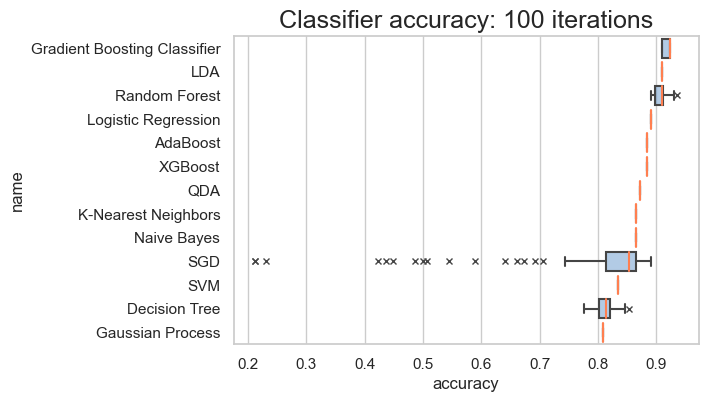

In [9]:
# Create the data
grouped_s = bl_scores.loc[:,['name', 'accuracy']] \
    .groupby(['name']) \
    .median() \
    .sort_values(by='accuracy', ascending = False)

# Set the figure properties
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid") 

# Figure
sns.boxplot(data= bl_scores, x="accuracy", y="name", 
            order = grouped_s.index,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
           ).set_title('Classifier accuracy: 100 iterations', fontsize=18);

#### Runtime of baseline models

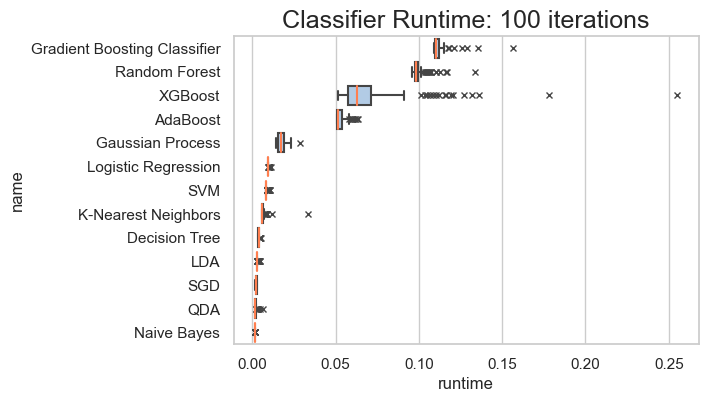

In [10]:
# Create the data
grouped_rt = bl_runtimes.loc[:,['name', 'runtime']] \
    .groupby(['name']) \
    .median() \
    .sort_values(by='runtime', ascending = False)

# Set the figure properties
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid") 

# Figure
sns.boxplot(data= bl_runtimes, x="runtime", y="name", 
            order = grouped_rt.index,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
           ).set_title('Classifier Runtime: 100 iterations', fontsize=18);

Below we present the aggregated results (average and median) for each classifier across all iterations.

In [11]:
# Compute the median and average accuracy and runtime; sort by decreasing accuracy and increasing runtime
bl_agg = bl_results.groupby(['name']).agg({'accuracy': ['mean', 'median'], 'runtime': ['mean', 'median']})
bl_agg.columns = ['_'.join(col) for col in bl_agg.columns]
bl_agg = bl_agg[['accuracy_mean', 'runtime_mean']].sort_values(['accuracy_mean', 'runtime_mean'], ascending = [0,1]).reset_index()
bl_agg = bl_agg.rename(columns = {'accuracy_mean': 'bl_acc', 'runtime_mean': 'bl_runtime'})
bl_agg

,name,bl_acc,bl_runtime
0,Gradient Boosting Classifier,0.917372,0.112332
1,LDA,0.910256,0.002777
2,Random Forest,0.907179,0.099899
3,Logistic Regression,0.891026,0.009464
4,AdaBoost,0.884615,0.052988
5,XGBoost,0.884615,0.072941
6,QDA,0.871795,0.002106
7,Naive Bayes,0.865385,0.001429
8,K-Nearest Neighbors,0.865385,0.006681
9,SVM,0.833333,0.008371


<font color = 'red'> SIIA KIRJUTADA JÄRELDUSED: MIS OLID TOP ALGORITMID </font>

Let us now zoom in on the five best classifiers and choose them for hyperparameter optimization.

In [12]:
# Add the best average accuracies and runtimes to the `df_models` dataframe defined earlier
df_models = df_models2.merge(bl_agg).sort_values(['bl_acc', 'bl_runtime'], 
                                                ascending = [0,1]).reset_index(drop = True)


# Choose the top 5 baseline classifiers
top_k = 5 # can be changed if needed
df_best_bl = df_models.iloc[:top_k] # choose only the top algos' aggregated results
df_best_bl[['name', 'bl_acc', 'bl_runtime']]

,name,bl_acc,bl_runtime
0,Gradient Boosting Classifier,0.917372,0.112332
1,LDA,0.910256,0.002777
2,Random Forest,0.907179,0.099899
3,Logistic Regression,0.891026,0.009464
4,AdaBoost,0.884615,0.052988


## Hyperparameter optimization
The following section is divided into two parts: (1) the `hyperopt` approach and the `hyperopt-sklearn` approach. The difference between these two is that while `hyperopt` generally requires user-defined, manually mapped search spaces for model hyperparameters, `hyperopt-sklearn` also provides the possibility for not manually defining the search spaces, and making the searches on its own automatically.

### The `hyperopt` approach
A great resource for hyperparameter optimization using the `hyperopt` library can be found [here](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce). The `hyperopt` Python module implements Bayesion Hyperparameter Optimization (HPO), and within this module, one needs to define manually the search space for a given model/classifier.

With the following codeblock, we are implementing the HPO by iterating over the selected classifiers and their manually-defined search spaces. The best classifiers as well as their potential search space is saved in the previous section into the `df_best_bl` dataframe.

In [13]:
# Initialize a dataframe for results collection
hpo_results = pd.DataFrame(columns = ['classifier_name', 'best_cv_score', 'runtime_hpo', 'best_params', 'test_acc'])

# Define the best baseline score
best_baseline_score = df_best_bl.loc[0, 'bl_acc']

# Define how many iterations should be done
n_trials = 100

# All individual trials will be saved here
trials_dict = {}

# Start the timer to measure the runtime of the entire pipeline
hpo_time_start = time.time()

# Run the HPO and get the best params for each classifier
for i in range(len(df_best_bl)):
    
    # To improve the raedability of code, creating the following objects:
    classifier_name = df_best_bl.loc[i, 'name']
    classifier_class = classifiers[names.index(classifier_name)] # fetch from the list not df for baseline
    classifier_search_space = df_best_bl.loc[i, 'search_space']
    
  #  sp = search_spaces[names.index(df_best_bl.loc[i, 'name'])]
    
    # To improve the readability of output:
    print()
    print('----------------------------------------------------------------------')
    print(f'Using *{classifier_name}* for estimation.')
    print('----------------------------------------------------------------------')
    
    # A helper function for receiving the CV scores for each model
    def hyperopt_cv_score(params):
        cv = RepeatedKFold(n_splits=5, n_repeats=5) # can be also adjusted!
        model = classifier_class.set_params(**params) # use the classifier from the list
        return cross_val_score(model, 
                               X_train, y_train, 
                               cv = cv,  
                               scoring = 'accuracy',
                               error_score='raise').mean() 

    # A helper function for finding the best model
    def f(params):
        global best_cv_score
        global best_params
        global best_time
        
        cv_score = hyperopt_cv_score(params)
    
        if cv_score > best_cv_score:
            # Are we bearing the best baseline score?
            if cv_score > best_baseline_score: # we are beating the baseline accuracy
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params
                
                print(f'*{classifier_name}* BEAT THE BASELINE of {best_baseline_score}!')
                print(f'Better CV score: {best_cv_score}')
                print(f'Parameter combination: {best_params}')
                print(f'Time until beating the baseline: {best_time}s')
            else: 
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params

                # Print the results for reference
                print(f'New best CV score: {best_cv_score}')
                print(f'New best params: {best_params}')
                print(f'Time taken until new best combination found: {round(best_time, 5)}s')

        return {'loss': -cv_score, # see the comment below
                'status': STATUS_OK}
        # Comment regarding 'negative cv_score' (from the referenced source):
        ## Since we are trying to maximize the CV score (cv_score in the code above), 
        ## we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
        ## Minimizing a function f is the same as maximizing the negative of f.
        ## About FMIN: https://github.com/hyperopt/hyperopt/wiki/FMin
        
    # Defining global variables to be updated
    best_cv_score = 0 # best CV score
    best_params = None # best hyperparameter combination
    best_time = 0 # runtime until the best CV score is computed
    trials = Trials() # store info at each step
    
    # Start running the algorithm and track time
    start_time = time.time()
    ## Objective function
    best = fmin(f, 
                classifier_search_space, # use the search space associated with the classifier
                algo = tpe.suggest, 
                max_evals = n_trials, # how many evaluations?
                trials = trials)
    # Save all trials
    trials_dict[classifier_name] = trials # save into classifier-trials 
    
    print()
    print('######################################################################')
    # Print the summary of the best results
    print(f'Best CV score in {n_trials} iterations: {best_cv_score} ({best_time}s until found).')
    
    # Compute the accuracy score on the best model of the classifier
    m = classifier_class.set_params(**best_params).fit(X_train, y_train)
    score_test = m.score(X_test, y_test)
    print(f'Accuracy score on test data: {score_test}.')
    
    
    # Append the best results to the df
    hpo_results = hpo_results.append({'classifier_name': classifier_name, 
                             'best_cv_score': best_cv_score, 
                             'runtime_hpo': best_time, 
                             'best_params': best_params,
                             'test_acc': score_test}, ignore_index = True)

# Mark the end of the entire pipeline
hpo_time_end = time.time()
print()
print('######################################################################')
print(f'The duration of the entire HPO pipeline for {len(df_best_bl)} classifiers across {n_trials} trials each: ')
print(f'{round(hpo_time_end - hpo_time_start, 5)} seconds')

# Sort the model results by test accuracy score and then Runtime
hpo_results = hpo_results.sort_values(['test_acc', 'runtime_hpo'], ascending = [0,1]).reset_index(drop = True)


----------------------------------------------------------------------
Using *Gradient Boosting Classifier* for estimation.
----------------------------------------------------------------------
New best CV score: 0.8598667998667999                                           
New best params: {'learning_rate': 0.26368205347355284, 'max_depth': 17, 'n_estimators': 165, 'subsample': 0.9121877383311242}
Time taken until new best combination found: 8.1997s                            
New best CV score: 0.8629503829503828                                           
New best params: {'learning_rate': 0.16836815284113787, 'max_depth': 14, 'n_estimators': 166, 'subsample': 0.7547211158820949}
Time taken until new best combination found: 27.8276s                           
New best CV score: 0.8644355644355644                                           
New best params: {'learning_rate': 0.24907334622623156, 'max_depth': 14, 'n_estimators': 79, 'subsample': 0.6349666702242371}
Time taken until ne

Time taken until new best combination found: 4.3837s                            
100%|██████| 100/100 [00:21<00:00,  4.62trial/s, best loss: -0.8417249417249415]

######################################################################
Best CV score in 100 iterations: 0.8417249417249415 (4.3837s until found).
Accuracy score on test data: 0.8782051282051282.

----------------------------------------------------------------------
Using *AdaBoost* for estimation.
----------------------------------------------------------------------
New best CV score: 0.864975024975025                                            
New best params: {'learning_rate': 0.2419174396233618, 'n_estimators': 66}      
Time taken until new best combination found: 1.5988s                            
New best CV score: 0.8664735264735265                                           
New best params: {'learning_rate': 0.18252231282488046, 'n_estimators': 73}     
Time taken until new best combination found: 3.3462s         

In [14]:
# Add a clumn which says if the classifier beat the baseline
hpo_results['beats_bl'] = np.where(hpo_results.loc[:,'test_acc'] > best_baseline_score, 'yes', 'no')

# See the HPO results
hpo_results

,classifier_name,best_cv_score,runtime_hpo,best_params,test_acc,beats_bl
0,Random Forest,0.878428,90.8283,"{'max_features': 'sqrt', 'min_samples_split': ...",0.923077,yes
1,AdaBoost,0.870603,181.3984,"{'learning_rate': 0.06743809952223032, 'n_esti...",0.916667,no
2,Gradient Boosting Classifier,0.878874,357.6782,"{'learning_rate': 0.0963595080519802, 'max_dep...",0.897436,no
3,LDA,0.849431,4.8314,"{'shrinkage': 0.5863251597387508, 'solver': 'l...",0.884615,no
4,Logistic Regression,0.841725,4.3837,"{'C': 0.07237993941940565, 'l1_ratio': 0.79141...",0.878205,no


All of these models have generally fared off pretty well. Out of these solutions, which model reached their best score with the least amount of time and beat the baseline?

In [15]:
bl_beaters = hpo_results[(hpo_results['beats_bl'] == 'yes')]
bl_beaters[bl_beaters['runtime_hpo'] == bl_beaters['runtime_hpo'].min()]

,classifier_name,best_cv_score,runtime_hpo,best_params,test_acc,beats_bl
0,Random Forest,0.878428,90.8283,"{'max_features': 'sqrt', 'min_samples_split': ...",0.923077,yes


Let's plot the model test set accuracy against runtime.

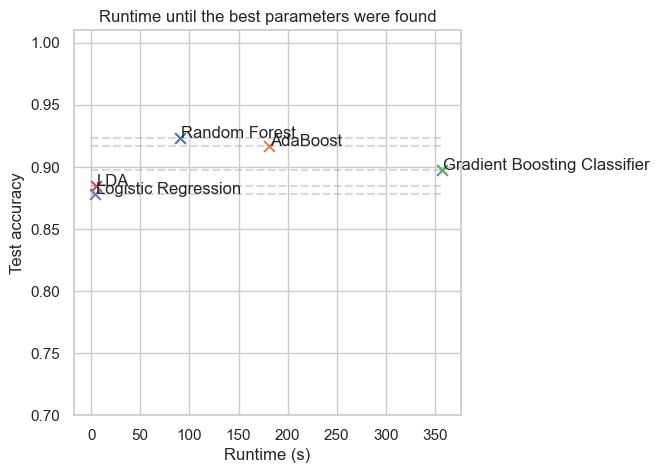

In [16]:
plt.figure(figsize = [5, 5])

for i in range(len(hpo_results)):
    # Add classifier values
    plt.scatter(hpo_results['runtime_hpo'][i], 
            hpo_results['test_acc'][i], 
            label = hpo_results['classifier_name'][i],
               marker = 'x',
               s = 60)
    # Add a dashed lined marking the best accuracy threshold for classifier
    plt.hlines(y = hpo_results['test_acc'][i], 
               xmin=0, 
               xmax = np.max(hpo_results['runtime_hpo'])+1,
              linestyles = 'dashed', alpha = 0.3, color = 'grey')
    # Add classifier name
    plt.annotate(hpo_results['classifier_name'][i], 
                 (hpo_results['runtime_hpo'][i]+1, 
                  hpo_results['test_acc'][i]),
                )
plt.ylim(bottom = 0.70, top = 1.01)
plt.xlabel('Runtime (s)')
plt.ylabel('Test accuracy')
plt.title('Runtime until the best parameters were found')
plt.show();

In addition to displaying the best accuracies and runtimes of each classifier, let's also look into how the accuracy scores were associated with different values of hyperparameters. For that, we first define a helper function that take classifier and its trials' related information as input and provides the parameter value-accuracy figure as output. We then iterate over all models to display the values of parameters in relation to accuracy scores accross all trials.

In [17]:
def params_plot(classifier_name, trials, parameters):
    """Parameters plot from trials
    Args:
        classifier_name (str): the name of the classifier
        trials (trials obj): all trials from runs
        parameters (list): list of parameters to be plotted
    
    Returns: 
        plot for parameter performance across trials
    """
    # Define the figure (make a 2x3 grid universally)
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,5))
    f.suptitle(f'{classifier_name} HP performance across {len(trials)} trials') # set the plot title
    f.tight_layout()

    cmap = plt.cm.jet
    for i, val in enumerate(parameters):
        # Getting the hyperparameter and loss values with list comprehension
        xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
        ys = [-t['result']['loss'] for t in trials.trials]
        # Making the necessary sorting
        xs, ys =  zip(*sorted(zip(xs, ys)))
        ys = np.array(ys)

        # Plot
        axes[int(i/3),int(i%3)].scatter(xs, ys, 
                              s=10, 
                              linewidth=0.01, 
                             # alpha= 0.5,
                              color=cmap(float(i)/len(parameters))
                                       )
        axes[int(i/3),int(i%3)].set_title(val)
        axes[int(i/3),int(i%3)].set_ylim([0.2,1.0])

    plt.show();

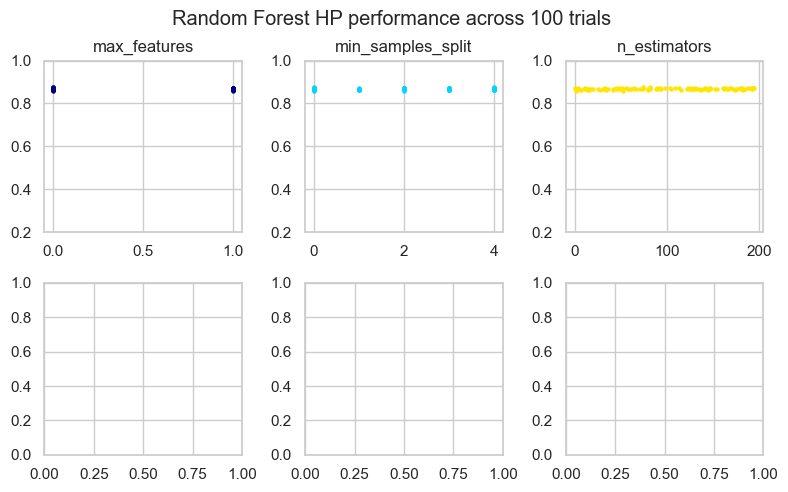

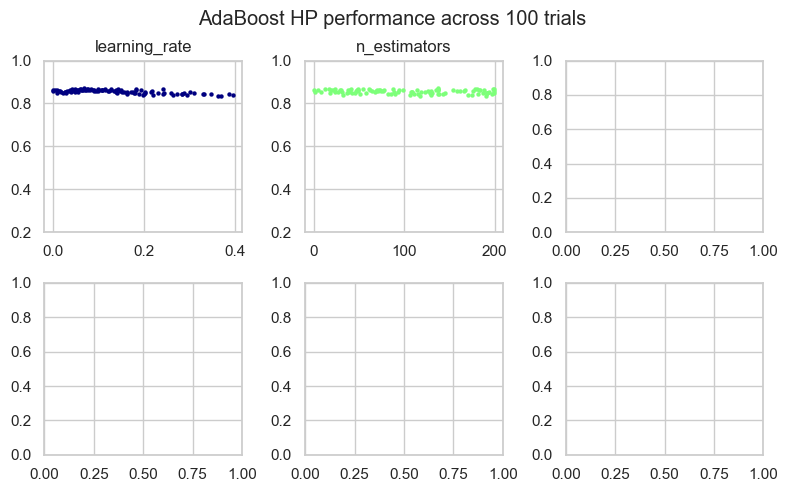

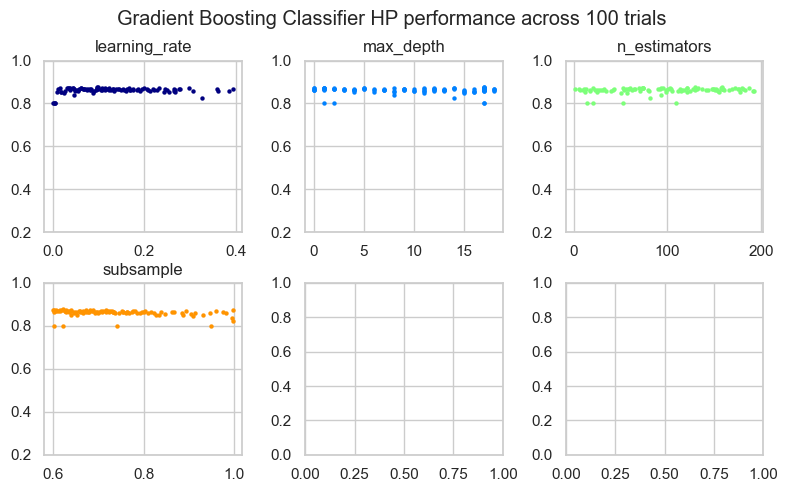

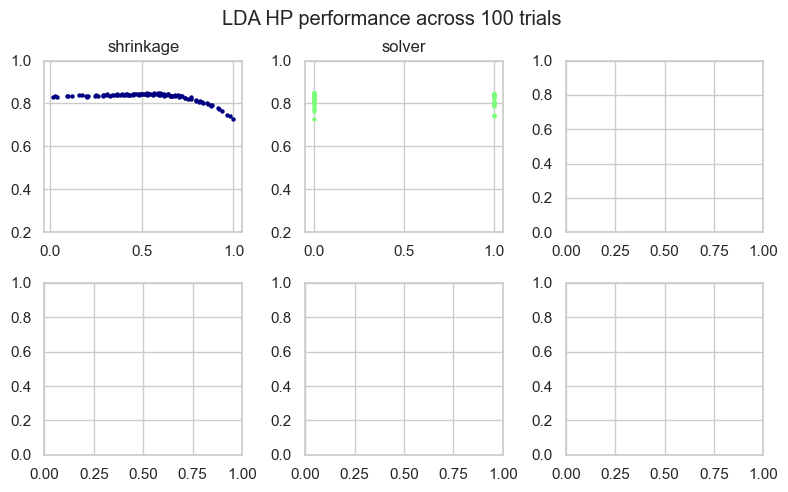

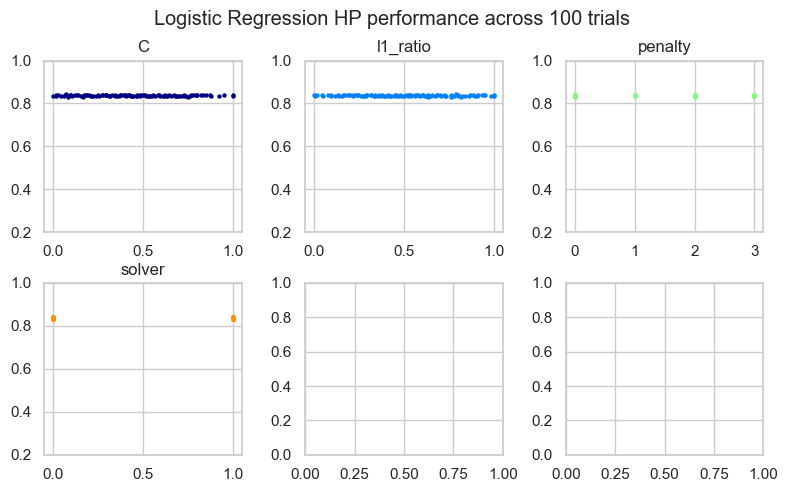

In [18]:
for i in range(len(hpo_results)):
    classifier_name = hpo_results.loc[i, 'classifier_name']
    trials = trials_dict[classifier_name]
    parameters = hpo_results.loc[i, 'best_params'].keys()
    # figure
    params_plot(classifier_name, trials, parameters)

# Significance testing 
In the below section, we will test whether the differences between the models are statistically significant. For that, we will use pairwise McNemar test to compare each model with each other. P-values have the continuity correction.


In [19]:

sig_test_classifiers = [] # insantiate classifier name list
cv_scores = {} # instantiate a dictionary for CV scores collection

for i in range(len(hpo_results)):
    # Remove spaces from classifier name
    classifier_name = hpo_results.loc[i, 'classifier_name'].replace(' ', '')
    
    # Fit the model with the best params (are saved in the env), compute CV scores
    model1 = classifiers[names.index(hpo_results.loc[i, 'classifier_name'])].fit(X_train, y_train)
    folds5 = RepeatedKFold(n_splits = 5, n_repeats = 20, random_state = 2022) # 5 splits, 20 repeats = 100 samples per algo
    scores = cross_val_score(model1, X_test, y_test, scoring = "accuracy", cv = folds5)
    # Save cv scores and the classifier name
    cv_scores[classifier_name] = scores
    sig_test_classifiers.append(classifier_name)

cv_scores = pd.DataFrame(cv_scores)
cv_scores.head()

,RandomForest,AdaBoost,GradientBoostingClassifier,LDA,LogisticRegression
0,0.843750,0.875000,0.875000,0.781250,0.843750
1,0.967742,0.870968,0.903226,0.935484,0.870968
2,0.935484,0.935484,0.967742,0.870968,0.838710
3,0.774194,0.741935,0.774194,0.741935,0.709677
4,0.903226,0.903226,0.935484,0.903226,0.903226


In [20]:
# Friedman test
stat, p = friedmanchisquare(cv_scores.iloc[:,0],
                            cv_scores.iloc[:,1],
                            cv_scores.iloc[:,2],
                            cv_scores.iloc[:,3],
                            cv_scores.iloc[:,4]
                           )

if p < 0.001:
    print('Friedman chi-squared statistic = %.3f, p < 0.001.' % (stat))
else:
    print('Friedman chi-squared statistic = %.3f, p = %.3f' % (stat, p))
    
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0).')   

Friedman chi-squared statistic = 78.335, p < 0.001.
Different distributions (reject H0).


In [21]:
#perform Nemenyi post-hoc test
nm_test = sp.posthoc_nemenyi_friedman(np.array(cv_scores))
nm_test.columns = sig_test_classifiers
nm_test.index = sig_test_classifiers

print('Nemenyi post hoc test results (pairwise comparison p-values):')
nm_test

Nemenyi post hoc test results (pairwise comparison p-values):


,RandomForest,AdaBoost,GradientBoostingClassifier,LDA,LogisticRegression
RandomForest,1.000000,0.618550,0.044163,0.002282,0.001000
AdaBoost,0.618550,1.000000,0.001000,0.151040,0.071613
GradientBoostingClassifier,0.044163,0.001000,1.000000,0.001000,0.001000
LDA,0.002282,0.151040,0.001000,1.000000,0.900000
LogisticRegression,0.001000,0.071613,0.001000,0.900000,1.000000


<font color = 'red'> SIIA MINGID COMMENTID </font>

<font color = 'red'> JÄRGNEV HYPEROPT-SKLEARN OSA VÕIB OLLA TEG VÄGA OPTIONAL, VÕIME KA VÄLJA JÄTTA </font>

## The `hyperopt-sklearn` approach
In <font color = 'red'> SECTION </font>, we provided the definition for the search space of each selected classifier. However, `hyperopt` can also function without explicitly specifying the search space - enter `hyperopt-sklearn`, a presently developed library (see [here](https://github.com/hyperopt/hyperopt-sklearn)) that provides more automation for hyperparameter optimization. `hyperopt-sklearn` has support for a deecnt number of classifiers, it allows to automatically search for the best models from either within all possible model classes or from a user-defined set of models; it is possible to implement data preprocessing (a functionality that we decided not to use during the present project) as well as define the search space manually or let the computer decide it randomly based on all possible hyperparameters. 

Below we will run the classifiers used above without specified search space. Of note, this might mean that some models will not compute or converge, since some hyperparameter combinations do not work together. In those cases, we just skip the hyperparameter combination and proceed.

The main advantage of `hyperopt-sklearn` is that we can reduce manual work in specifying hyperparameter space for each classifier. The main disadvantage is that some of the previously-used functions are not easily programmable here, i.e., the `hypropt-sklearn` is somewhat less flexible.

In [23]:
--- to create an error for precventing auto-run when restarting and running the notebook :)
    
# 1. Initialize a dataframe
model_results_auto = pd.DataFrame(columns = ['classifier', 'test_acc', 'best_params'])

# 2. Classifier labels
names_auto = [
    "Gradient Boosting Classifier",
    "LDA",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

# 3. Classifier classes
classifiers_auto = [
    gradient_boosting_classifier("gbc"),
    linear_discriminant_analysis('lda'),
    random_forest_classifier('rf'), 
    ada_boost_classifier('ada'), 
    logistic_regression('logreg')
]

# 4. Iterate over all classifiers
for i in range(len(classifiers_auto)):
    print()
    print(f'Using the *{names_auto[i]}* for estimation.')
    
    # Objective function
    estim = HyperoptEstimator(classifier = classifiers_auto[i],
                                    #  preprocessing=[],
                                      algo=tpe.suggest,
                                      max_evals=100)
    try:
        # Fit the model
        estim.fit(X_train, y_train)
        
        # Add the results to df
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': estim.score(X_test, y_test),
             'best_params': estim.best_model()
             }, 
            ignore_index = True)
    except:
        print('Model with params not computed')
        # Append the name but assign None-values to fields
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': None,
             'best_params': None
             }, 
            ignore_index = True)

model_results_auto = model_results_auto.sort_values(['test_acc'], ascending = False).reset_index(drop = True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 40)

Look at the results table:

In [ ]:
model_results_auto

## Bonus: Kaggle submission
Below is a little piece of code for external model validation with a holdout test set on Kaggle.

In [ ]:
--- to create an error
# Kaggle
## Use the best model to predict the target
bestm = GradientBoostingClassifier(**model_results['best_params'][0]).fit(X_train, y_train)
pred_best = bestm.predict(X_test)

# Prepare the submission df
submission_best1 = pd.DataFrame(
    {'station_id': X_test['station_id'], 'compliance_2021': pred_best},
    columns = ['station_id', 'compliance_2021']
).set_index('station_id')

# Write to .csv (for manual data submission)
submission_best1.to_csv('best_submission.csv')